<a href="https://colab.research.google.com/github/Alxchirayath/OpthoAI/blob/main/AC_Optho_macular_edema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Loading in our data and importing necessary packages
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_frame = pd.read_csv("/content/drive/MyDrive/Tempdata/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.0/labels.csv")
data_frame.head()

,image_id,patient_id,camera,patient_age,comorbidities,diabetes_time_y,insuline,patient_sex,exam_eye,diabetes,...,amd,vascular_occlusion,hypertensive_retinopathy,drusens,hemorrhage,retinal_detachment,myopic_fundus,increased_cup_disc,other,quality
0,img00001,1,Canon CR,48.0,diabetes1,12,yes,1,1,yes,...,0,0,0,0,0,0,0,1,0,Adequate
1,img00002,1,Canon CR,48.0,diabetes1,12,yes,1,2,yes,...,0,0,0,0,0,0,0,1,0,Adequate
2,img00003,2,Canon CR,18.0,diabetes1,7,yes,2,1,yes,...,0,0,0,0,0,0,0,0,0,Adequate
3,img00004,2,Canon CR,18.0,diabetes1,7,yes,2,2,yes,...,0,0,0,0,0,0,0,0,0,Adequate
4,img00005,3,Canon CR,22.0,diabetes1,11,yes,1,1,yes,...,0,0,0,0,0,0,0,0,0,Adequate


In [ ]:
new_data = data_frame[['image_id','macular_edema']]
new_data.head()

,image_id,macular_edema
0,img00001,0
1,img00002,0
2,img00003,0
3,img00004,0
4,img00005,0


In [ ]:

new_data['macular_edema'].value_counts()

0    15864
1      402
Name: macular_edema, dtype: int64

In [ ]:
# downsampling all classes to lowest count of 2807 X 3 (synthesize 2x copies of minority class)
class0_df = new_data[new_data['macular_edema'] == 0].sample(n=1206)
class1_df = new_data[new_data['macular_edema'] == 1]
new_data = pd.concat([class0_df, class1_df])
new_data.shape

(1608, 2)

In [ ]:
new_data.head(1)

,image_id,macular_edema
1306,img01307,0


In [ ]:
import shutil
import os
from tqdm import tqdm

# specify directory to move images to
source_directory = "/content/drive/MyDrive/Tempdata/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.0/fundus_photos"
data_dir = "/content/drive/MyDrive/macular"

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# make class files
num_classes = new_data['macular_edema'].nunique()
class_directories = {}

for i in range(num_classes):
  class_directory = os.path.join(data_dir, str(i))
  os.makedirs(class_directory, exist_ok=True)
  class_directories[i] = class_directory

for i in tqdm(range(len(new_data))):
  # get filename
  file_name = new_data['image_id'].iloc[i] + ".jpg"
  source = os.path.join(source_directory, file_name)

  # check if file exists
  if os.path.exists(source):
    # check label and move to appropriate directory
    class_label = new_data['macular_edema'].iloc[i]
    target_directory = class_directories[class_label]
    #shutil.copy(source, target_directory)
    if class_label == 0:
      shutil.copy(source, target_directory)
    elif class_label == 1:
      shutil.copy(source, target_directory)
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_1.jpg"))
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_2.jpg"))

100%|██████████| 1608/1608 [00:25<00:00, 62.87it/s] 


In [ ]:
import os
for dir in os.listdir(data_dir):
  print(dir, len(os.listdir(os.path.join(data_dir, dir))))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/macular'

In [ ]:
# Data preparation
from tqdm import tqdm
import tensorflow as tf
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Define the size of your images and batch size
img_height = 224
img_width = 224
batch_size = 32

if num_classes <= 2:
  label_mode = 'binary'
else:
  label_mode = 'categorical'

# Function to extract labels from the dataset
def get_labels(dataset):
      labels = np.concatenate([y.numpy() for x, y in tqdm(dataset)], axis=0)
      return labels

# Train/test split
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/macular',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  label_mode=label_mode,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/macular',
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode=label_mode,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Define the augmentation layer
data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.1),
  layers.RandomZoom(0.1),
  layers.RandomHeight(0.1),
  layers.RandomWidth(0.1),
  layers.RandomBrightness(0.1),
  layers.RandomTranslation(0.1, 0.1),
])

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

AUTOTUNE = tf.data.experimental.AUTOTUNE if hasattr(tf.data, 'experimental') else tf.data.AUTOTUNE

augmented_train_ds = augmented_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create a normalization layer and apply it to the training and validation datasets
normalization_layer = layers.Rescaling(1./255)

normalized_train_ds = augmented_train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


Found 1192 files belonging to 2 classes.
Using 954 files for training.
Found 1192 files belonging to 2 classes.
Using 238 files for validation.


In [ ]:
# Mobilnet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
import datetime

# HYPERPARAMETERS
INPUT_SHAPE = (224, 224, 3)
LR = 4e-5
DROPOUT = .25
TRANSFER_DROPOUT = .25
ALPHA = 1
BATCH_SIZE = 32
NUM_FREEZE = 80
NUM_EPOCHS = 30


def get_lr_metric(optimizer): # used for debugging
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

#Callbacks

# Set up TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_recall',  # Monitor validation loss
    patience=15,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

# Model Checkpoint callback
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Model/macular_model.h5',   # Path where to save the model
    monitor='val_recall',  # Monitor validation loss
    save_best_only=True  # Only save the best model
)


def MobileNet(num_freeze, num_classes, **kwargs):
    base_model = tf.keras.applications.MobileNet(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False, **kwargs)
    for i in range(num_freeze):
      base_model.layers[i].trainable = False

    model= tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(DROPOUT),
        Dense(512, activation='relu'),
        Dropout(DROPOUT),
        Dense(256, activation='relu'),
    ])
    if num_classes <= 2:
        model.add(Dense(1, activation='sigmoid'))
    else:
        model.add(Dense(num_classes, activation='softmax'))
    return model


In [ ]:
# Compile the model
model = MobileNet(num_freeze=NUM_FREEZE, num_classes=num_classes, dropout=TRANSFER_DROPOUT, alpha=ALPHA)
optimizer = Adam(learning_rate=LR)
if num_classes <= 2:
    loss = 'binary_crossentropy'
else:
    loss = 'categorical_crossentropy'

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
    ]
)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)              

In [ ]:
# Fit the model with callbacks
history = model.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=NUM_EPOCHS,
    verbose=True,
    class_weight=None,
    callbacks=[early_stopping, model_checkpoint,tensorboard_callback]  # Add callbacks here
)

Epoch 1/30
30/30 [==============================] - ETA: 0s - loss: 0.3726 - precision: 0.0588 - recall: 0.0260 - auc: 0.4524

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 44s 1s/step - loss: 0.3726 - precision: 0.0588 - recall: 0.0260 - auc: 0.4524 - val_loss: 0.2501 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6032
Epoch 2/30
30/30 [==============================] - 17s 556ms/step - loss: 0.2593 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7154 - val_loss: 0.2288 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7649
Epoch 3/30
30/30 [==============================] - 19s 638ms/step - loss: 0.2433 - precision: 1.0000 - recall: 0.0130 - auc: 0.7780 - val_loss: 0.2116 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8698
Epoch 4/30
30/30 [==============================] - 19s 644ms/step - loss: 0.2054 - precision: 1.0000 - recall: 0.0260 - auc: 0.8983 - val_loss: 0.1915 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9150
Epoch 5/30
30/30 [==============================] - 16s 552ms/step - loss: 0.1717 - precision: 1.0000 - recall: 0.

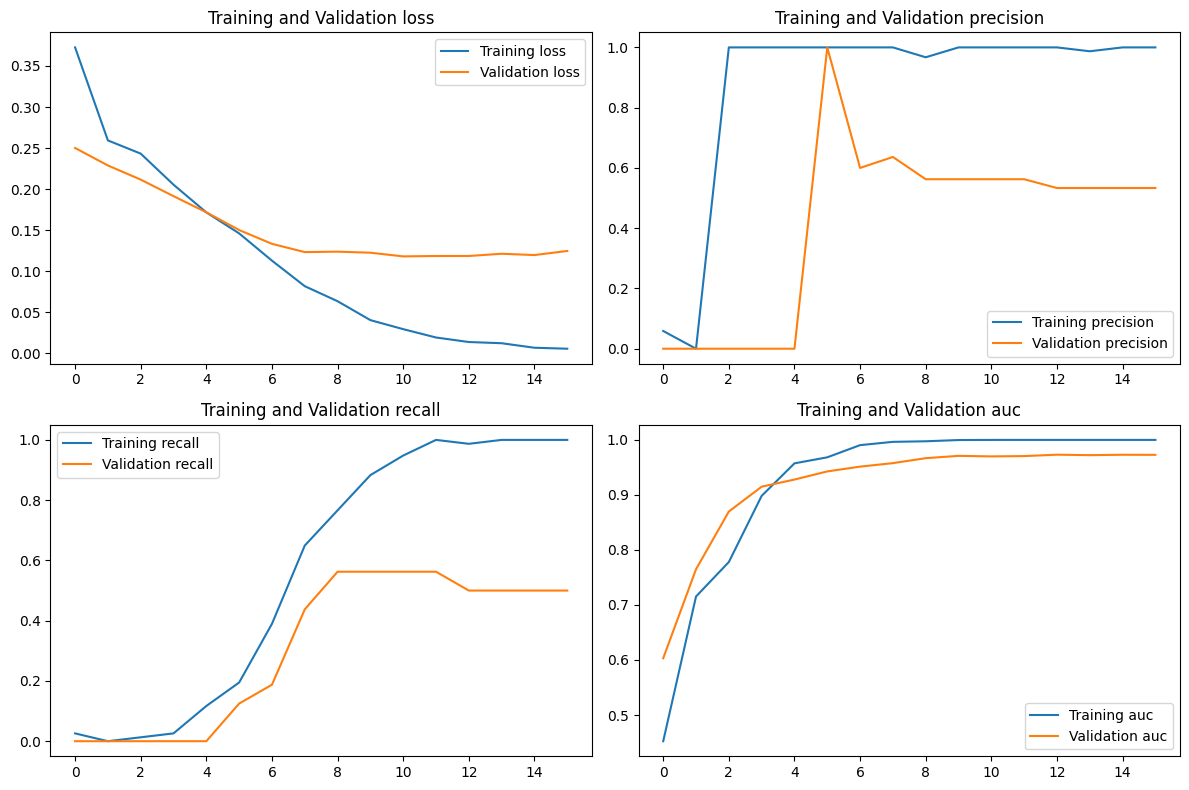

In [ ]:
import matplotlib.pyplot as plt

metric_keys = list(history.history.keys())
num_metrics = len(metric_keys) // 2  # Assuming there's a validation metric for each training metric
epochs_range = range(len(history.history[metric_keys[0]]))  # Number of epochs

# Calculate the number of rows needed (each row contains plots for one metric and its validation counterpart)
num_rows = (num_metrics + 1) // 2 if num_metrics % 2 != 0 else num_metrics // 2

plt.figure(figsize=(12, 4 * num_rows))  # Adjust the figure size

for i in range(num_metrics):
    metric = metric_keys[i]
    val_metric = metric_keys[i + num_metrics]  # Validation metric corresponding to the training metric

    plt.subplot(num_rows, 2, i + 1)
    plt.plot(epochs_range, history.history[metric], label=f'Training {metric}')
    plt.plot(epochs_range, history.history[val_metric], label=f'Validation {metric}')
    plt.legend(loc='best')
    plt.title(f'Training and Validation {metric}')

plt.tight_layout()
plt.show()


8/8 [==============================] - 3s 298ms/step
Confusion matrix:
[[222   0]
 [ 16   0]]


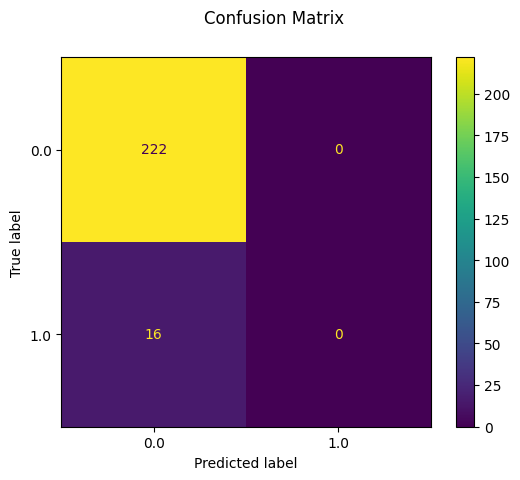

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97       222
         1.0       0.00      0.00      0.00        16

    accuracy                           0.93       238
   macro avg       0.47      0.50      0.48       238
weighted avg       0.87      0.93      0.90       238



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

threshold = 0.4

# Load the model
model = load_model('/content/drive/MyDrive/Model/macular_model.h5')

#y_val = normalized_val_ds.map(lambda x, y: y)
# Prepare true labels
y_true = np.concatenate([y for x, y in normalized_val_ds], axis=0)
if num_classes > 2:
  y_true = np.argmax(y_true, axis=1)
# Make predictions
predictions = model.predict(normalized_val_ds)
if num_classes > 2:
  predictions = np.argmax(predictions, axis=1)
predictions = (np.squeeze(predictions) > threshold).astype(int)

disp = ConfusionMatrixDisplay.from_predictions(y_true, predictions)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

# Compute confusion matrix and classification report
#cm = confusion_matrix(y_true, predictions)
#sns.heatmap(cm, annot=True, fmt="d")
#plt.show()

print(classification_report(y_true, predictions))

In [ ]:
# Test model by supplying various images
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
from tensorflow.keras import layers

### Provide inputs
# Pick a raw unmodified image
imgpath = '/content/drive/MyDrive/AI/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.0/fundus_photos/img15763.jpg'
# Load previously saved models
model_drprog = '/content/drive/MyDrive/Model/glaucoma2_model.h5'

# Downscale image to fit training resolution
image = load_img(imgpath, target_size=(224, 224))
input_image = img_to_array(image)
input_image = input_image/255 #Normalize to 0-1 range
input_image = input_image.reshape(1, 224, 224, 3)  # Add batch dimension and match model input shape

# Load the model
model = load_model(model_drprog)

# Make predictions
predictions = model.predict(input_image)
print(predictions)
#predictmax = np.argmax(predictions, axis=1)
#predictions = (np.squeeze(predictions) > threshold).astype(int)
predictprob = predictions[0][0] * 100

print("Prediction for Image probability",  predictprob,'%')



FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/AI/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.0/fundus_photos/img15763.jpg'